In [7]:
from fasp.loc import sbcgcDRSClient, DRSMetaResolver
from IPython.display import Image
import requests

drsClient = sbcgcDRSClient('/Users/forei/.keys/sevenbridges_keys.json', 's3')
tile_drs_id ='602db3568887dd4ba02c8065'
print(drsClient.getObject(tile_drs_id))
tile_url = drsClient.getAccessURL(tile_drs_id)
Image(url=tile_url) 


{'id': '602db3568887dd4ba02c8065', 'name': '5-13-11.jpg', 'size': 7452, 'checksums': [{'type': 'etag', 'checksum': '9a2afd36c2facc04a186676ea792043b-1'}], 'self_uri': 'drs://cgc-ga4gh-api.sbgenomics.com/602db3568887dd4ba02c8065', 'created_time': '2021-02-18T00:22:46Z', 'updated_time': '2021-02-18T00:22:46Z', 'mime_type': 'application/json', 'access_methods': [{'type': 's3', 'region': 'us-east-1', 'access_id': 'aws-us-east-1'}]}


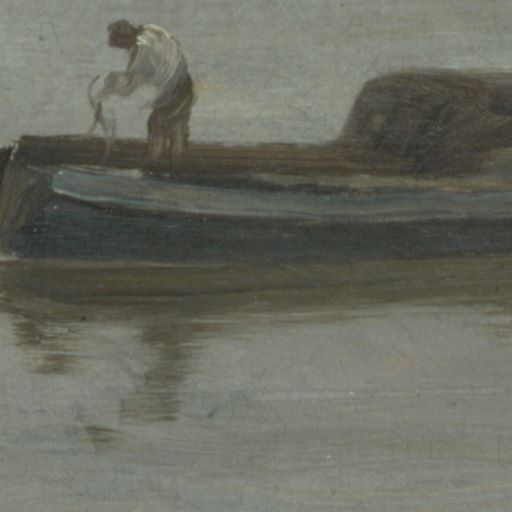

In [8]:
from PIL import Image as pim
tile_drs_ids = [['602db3568887dd4ba02c8065','602db35e46a9011329158100'],
['602db3568887dd4ba02c8068','602db35e8887dd4ba02c8099']]
def assembleImage(idGrid):
    cols = len(idGrid[0])
    rows = len(idGrid)
    cw = 256
    ch = 256
    final_im = pim.new('RGB', (cw * cols, ch * rows))
    y_offset = 0
    for r in idGrid:
        x_offset = 0
        for c in r:
            im = pim.open(requests.get(drsClient.getAccessURL(c), stream=True).raw)
            final_im.paste(im, (x_offset,y_offset))
            x_offset += cw
        y_offset += ch
    return final_im

assembleImage(tile_drs_ids)

In [9]:
def assembleImage(idGrid, label=False):
    from PIL import ImageDraw
    mr = DRSMetaResolver(getReg=False)
    
    cols = len(idGrid[0])
    rows = len(idGrid)
    cw = 256
    ch = 256
    final_im = pim.new('RGB', (cw * cols, ch * rows))
    y_offset = 0
    for r in idGrid:
        x_offset = 0
        for c in r:
            im = pim.open(requests.get(mr.getAccessURL(c), stream=True).raw)
            if label:
                sourceLabel = 'data/{}.jpg'.format(c.split(':')[0])
                overlay = pim.open(sourceLabel)
                mask = pim.open(sourceLabel).convert('L')
                im = pim.composite(im, overlay, mask)
            final_im.paste(im, (x_offset,y_offset))
            x_offset += cw
        y_offset += ch
    return final_im

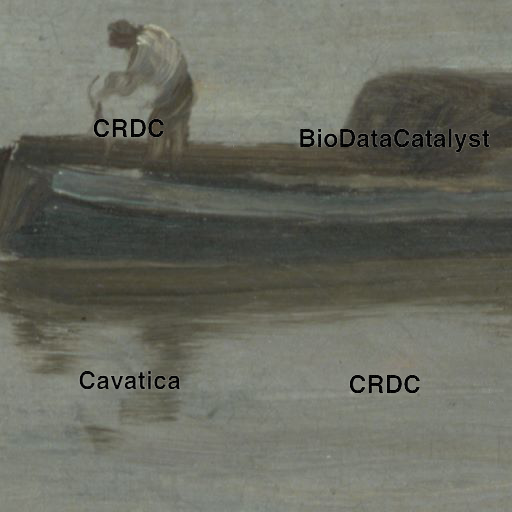

In [10]:
federated_tile_drs_ids = [['sbcgc:602db3568887dd4ba02c8065','sbbdc:601ff5dbd86c36184354dec4'],
['sbcav:601ff3fe42e8973aba24f0fb','sbcgc:602db35e8887dd4ba02c8099']]
assembleImage(federated_tile_drs_ids, True)

In [11]:
class PyramidViewer:
    
    def __init__(self, cols, rows, pyramidFile):
        self.cw = 256
        self.ch = 256
        self.cols = cols
        self.rows = rows
        self.final_im = pim.new('RGB', (self.cw * cols, self.ch * rows))
        self.grid = []
        for r in range(rows):
            self.grid.append([None] * cols)
        self.mr = DRSMetaResolver(getReg=False)

        import json
        with open(pyramidFile) as f:
            self.pyramid = json.load(f)

    def assembleImage(self):
        
        y_offset = 0
        for r in self.grid:
            x_offset = 0
            for c in r:
                if c != None:
                    im_url = self.mr.getAccessURL(c)
                    im = pim.open(requests.get(im_url, stream=True).raw)
                    self.final_im.paste(im, (x_offset,y_offset))
                x_offset += self.cw
            y_offset += self.ch
        return self.final_im
    
    def setPyramid(self, pyramid):
        self.pyramid=pyramid


    def getCurrentView(self, x, y, level):
        viewWidthTiles = 2
        viewHeightTiles = 2

        view_im = pim.new('RGB', (self.cw * viewWidthTiles, self.ch * viewHeightTiles))
        y_offset = 0
        grid = self.pyramid[str(level)]
        for r in grid[y:y+viewHeightTiles]:
            x_offset = 0
            for c in r[x:x+viewWidthTiles]:
                if c != None:
                    im_url = self.mr.getAccessURL(c)
                    im = pim.open(requests.get(im_url, stream=True).raw)
                    view_im.paste(im, (x_offset,y_offset))
                x_offset += self.cw
            y_offset += self.ch
            zoom = pow(2, level)
        print("xTile:{} yTile:{} level:{} zoom:x{}".format(self.currentX, self.currentY, self.currentLevel,zoom))
        return view_im


        
    def startViewer(self, xTile, yTile, level):
        self.currentLevel = level
        self.currentX = xTile
        self.currentY = yTile
        return self.getCurrentView(xTile, yTile, level)


    def scroll(self, xIncrement, yIncrement):
        self.currentX += xIncrement
        self.currentY += yIncrement
        return self.getCurrentView(self.currentX, self.currentY, self.currentLevel)    
    
    def zoom(self, levelChange):
        self.currentLevel +=levelChange
        if levelChange > 0:
            self.currentX = int(self.currentX * 2 * levelChange)
            self.currentY = int(self.currentY * 2 * levelChange)

        if levelChange < 0:
            self.currentX = int(self.currentX / abs(2 * levelChange))
            self.currentY = int(self.currentY / abs(2 * levelChange))

        return self.getCurrentView(self.currentX, self.currentY, self.currentLevel)

xTile:13 yTile:11 level:5 zoom:x32


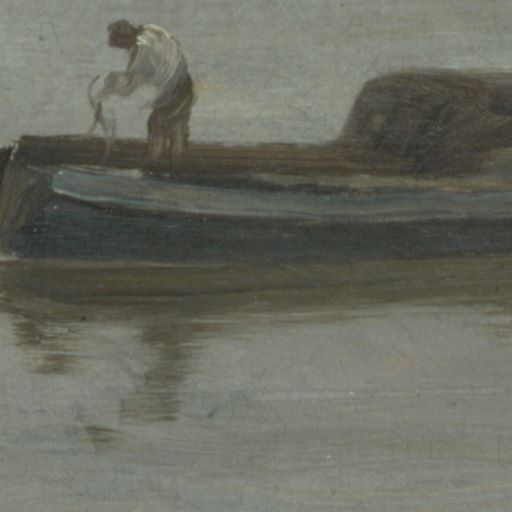

In [12]:
vwr = PyramidViewer(21,18, 'data/pyramid.json')
vwr.startViewer(13,11,5)

xTile:14 yTile:11 level:5 zoom:x32


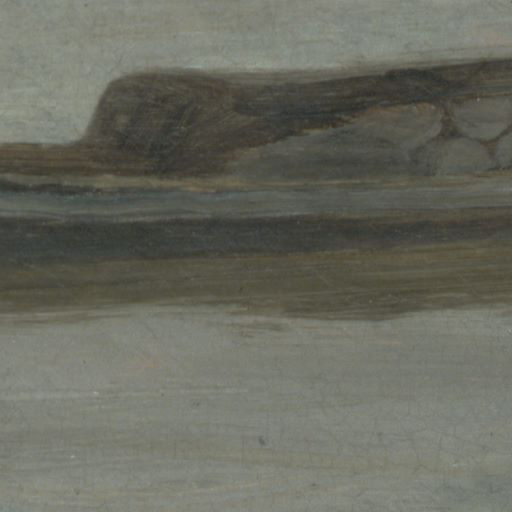

In [13]:
vwr.scroll(1,0)

xTile:3 yTile:2 level:3 zoom:x8


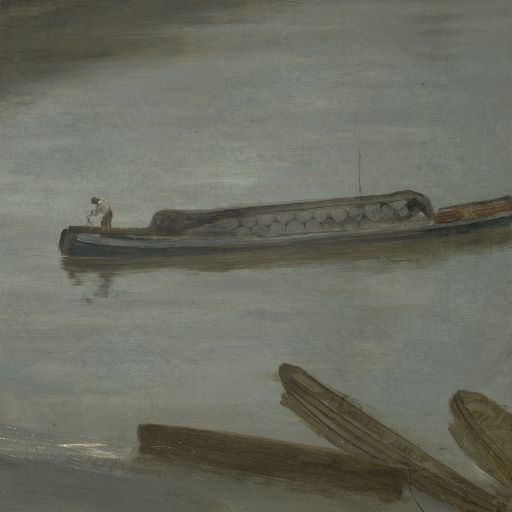

In [8]:
vwr.zoom(-2)

xTile:6 yTile:4 level:4 zoom:x16


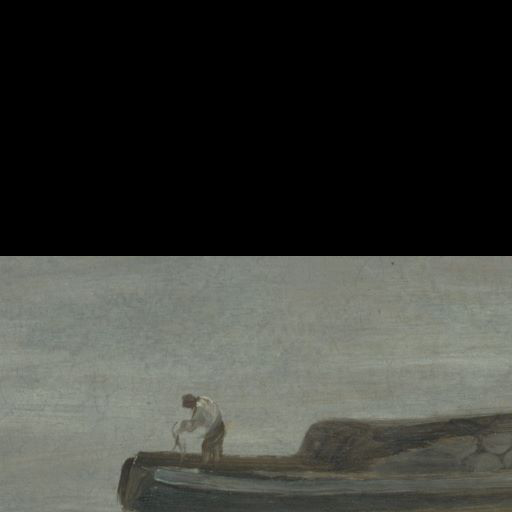

In [9]:
vwr.zoom(1)

Swan and Magpie
xTile:15 yTile:5 level:5 zoom:x32


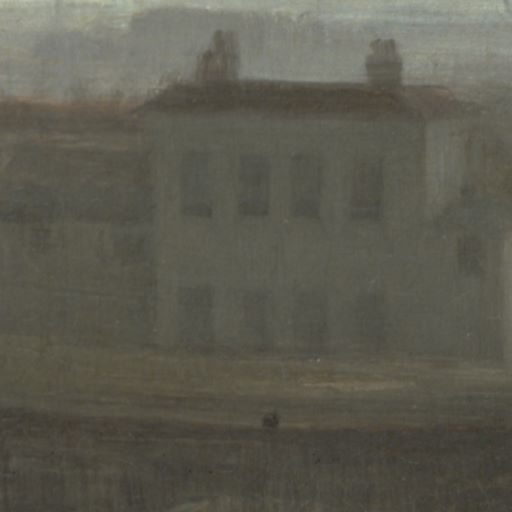

In [10]:
print("Swan and Magpie")
vwr.startViewer(15,5,5)